# Clustering

This problem set is more a demo than a real task for you to perform. All you need to do is read and execute the code below. Note the import statements in the first code block, which load the libraries responsible for the heavy lifting.

When you've run all the code blocks below, upload your copy of the notebook to Sakai as your submission. Again, the idea is just for you to have this in your back pocket for intellectual reference and to use as the basis for other corpus work.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize   import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.cluster  import KMeans
from sklearn.datasets import make_blobs

## Synthetic data

Here, we generate blobs of synthetic data, each distributed normally in two dimensions around a distinct center point. We then perform _k_-means clustering on the data and compare the cluster assignment to the original blob membership for each point.

In [2]:
# Generate some synthetic data

# Change centers below if you want to add/remove/relocate synthetic clusters
centers = np.array([(-0.6,0.05), (0.55,-0.05), (0, 1), (0, -1), (1.01, 0.99)])

data, labels = make_blobs(
    n_samples=10000, 
    n_features=2,
    centers=centers,
    cluster_std=0.25
)

# Convenience transforms for plotting
x_values = data[:,0]
y_values = data[:,1]
x_centers = centers[:,0]
y_centers = centers[:,1]

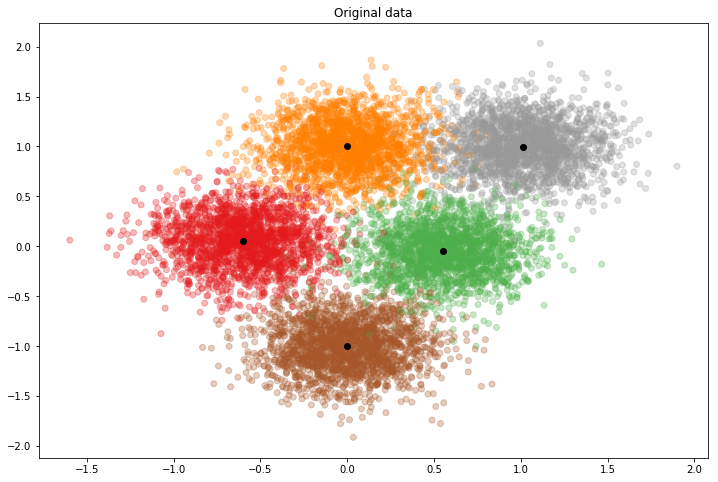

In [3]:
# Plot synthetic clusters
# Set plot defaults
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['image.cmap'] = 'Set1'

plt.scatter(x_values, y_values, c=labels, alpha=0.3) # Plot synthetic data points
plt.scatter(x_centers, y_centers, marker='o', c='black') # Synthetic centroids
plt.title("Original data")
plt.show()

In [13]:
# Perform k-means clustering
km = KMeans(n_clusters=len(centers)) # Set up clusterer
km.fit(data)                         # Fit data
klabels = km.labels_                 # Get cluster assignments
kcenters = km.cluster_centers_       # Get cluster centroids

In [14]:
# Align cluster labels to synthetic labels
# This is optional, but helps us to visualize overlap between true clusters and _k_-means output
cost = cdist(centers, kcenters) # How far apart is each true center from the cluster centroids?
row_ind, col_ind = linear_sum_assignment(cost) # Align to nearest true center
klabels_aligned = col_ind[klabels] # Transform clusters to align with originals

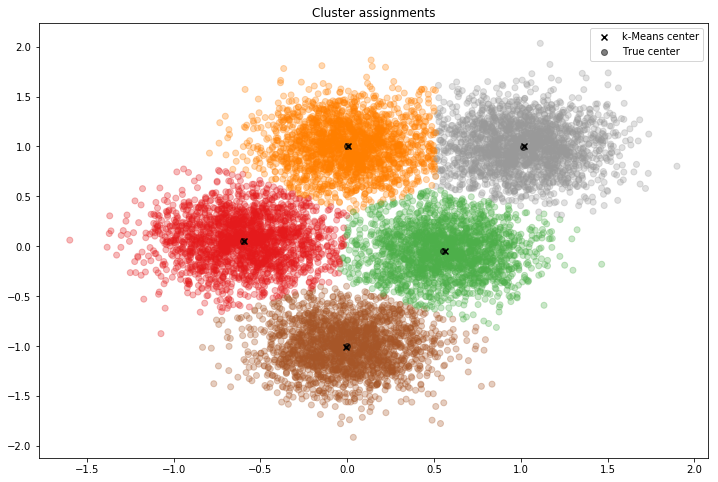

In [15]:
# Plot cluster assignments
plt.scatter(x_values, y_values, c=klabels_aligned, alpha=0.3)
plt.scatter(kcenters[:,0], kcenters[:,1], marker='x', c='black', label="k-Means center")
plt.scatter(x_centers, y_centers, marker='o', c='black', alpha=0.5, label="True center")
plt.title("Cluster assignments")
plt.legend()
plt.show()

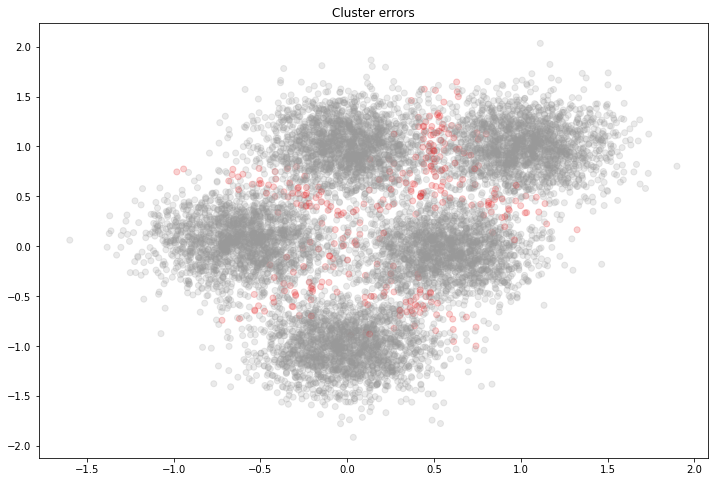

308 cluster errors among 10000 points


In [16]:
# Plot cluster deviations
label_diffs = abs(labels-klabels_aligned) > 0.001
plt.scatter(x_values, y_values, c=~label_diffs, alpha=0.2)
plt.title("Cluster errors")
plt.show()
print(f'{sum(label_diffs)} cluster errors among {len(label_diffs)} points')

## Literature data

OK, now we'll do the same thing, but with our 40-volume literary corpus. To do this on your own machine, you'll need a copy of that corpus and you may need to modify the code below to tell it where to find your copy of the corpus. This is perhaps all easiest if you just pull the entire class repo from GitHub. Just be sure not to overwrite your own work!

Note that the code below takes about 20 seconds to run on my laptop.

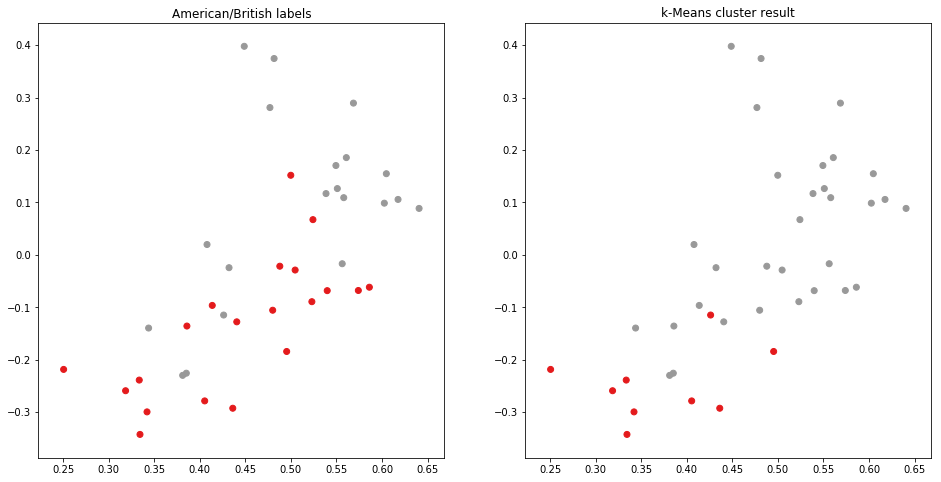

13 errors among 40 volumes


In [17]:
import os
from nltk.corpus.reader.plaintext import CategorizedPlaintextCorpusReader
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Location of the corpus texts
txt_dir = os.path.join('..', '..', 'data', 'texts') # <- MODIFY THIS LOCATION TO SUIT

# Set up an NLTK corpus reader
corpus = CategorizedPlaintextCorpusReader(
    txt_dir,              # corpus location
    r'.*\.txt',           # corpus files end in '.txt'
    cat_pattern=r'(\w).*' # corpus categories indicated by first letter of each file name
)

# Retrieve document categories and make numeric (for plot colors)
true_categories = [corpus.categories(fileids=[i])[0] for i in corpus.fileids()]
true_labels = [0 if i=='A' else 1 for i in true_categories]

# Vectorizer to texts into TFIDF-weighted features
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_df=0.7,
    min_df=2,
    binary=True,
    use_idf=True,
    norm='l2'
)

# Set up clustering object
clusterer = KMeans(
    n_clusters=2 # How many clusters for k-means?
)

# Set up dimension-reducer for plotting
reducer = TruncatedSVD(
    n_components=2 # Turn 20,000+ text dimensions into 2 for plotting
)

# A function to iterate over the documents in our corpus
def get_documents(corpus):
    """Get the corpuments from a corpus"""
    for fileid in corpus.fileids():
        yield corpus.raw(fileids=[fileid])
        
# Vectorize and cluster
features = vectorizer.fit_transform(get_documents(corpus)) # Documents -> features
clusterer.fit(features) # Perform k-means clustering
cluster_labels = clusterer.labels_ # Retrieve cluster assignments

# Align labels
cluster_centers = clusterer.cluster_centers_
    # Calculate true centers in high-dimensional space
true_centers = np.array([np.mean(features[:20,:], axis=0), np.mean(features[20:,:], axis=0)])[:,0,:]
cost = cdist(true_centers, cluster_centers)
row_ind, col_ind = linear_sum_assignment(cost)
cluster_labels_aligned = col_ind[cluster_labels]

# Plot results
plot_data = reducer.fit_transform(features) # Reduce dimensions for visualization
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(plot_data[:,0], plot_data[:,1], c=true_labels)
plt.title("American/British labels")
plt.subplot(1,2,2)
plt.scatter(plot_data[:,0], plot_data[:,1], c=cluster_labels_aligned)
plt.title("k-Means cluster result")
plt.show()

# Print error stats
cluster_diffs = abs(true_labels-cluster_labels_aligned) > 0.001
print(f'{sum(cluster_diffs)} errors among {len(cluster_diffs)} volumes')

## Optional

If you're feeling ambitious, you can try different settings for the vectorizer to see how they affect clustering output. The vectorizer is the piece responsible for counting words in the documents and assembling them into a feature matrix. Things like changing the stopword thresholds, performing inverse document weighting, etc. can have a meaningful impact on *what* you're clustering, hence on the shape of the output.

## Classification

Not part of the problem set, but let's take a look at how we would use the same data to predict the nationality of the authors in our corpus.

In [25]:
# Examine the features ...
print("Feature matrix shape:", features.shape)
print("Some feature names:\n", vectorizer.get_feature_names()[11000:11010])

Feature matrix shape: (40, 29287)
Some feature names:
 ['gala', 'galahad', 'galaxy', 'gale', 'galen', 'gales', 'galileo', 'gall', 'gallant', 'gallantly']


In [18]:
# Logistic regression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# Note that we've already produced the features and labels
X = features
y = true_categories
scores = cross_validate(LogisticRegression(solver='lbfgs'), X, y, cv=5)
print("Average score:", np.mean(scores['test_score']))

Average score: 0.775


In [26]:
%%time
# Now evaluate a bunch of classifiers
import warnings

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

classifiers = [
    AdaBoostClassifier(),
    BernoulliNB(),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    KNeighborsClassifier(),
    LinearSVC(),
    LogisticRegression(solver='liblinear'),
    #MLPClassifier(alpha=1), # Slow!
    NearestCentroid(),
    PassiveAggressiveClassifier(max_iter=1000, tol=1e-3),
    Perceptron(max_iter=1000, tol=1e-3),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    RidgeClassifier(tol=1e-2, solver="lsqr"),
    SGDClassifier(max_iter=1000, tol=1e-3),
    SVC(gamma=2, C=1)
]

X_dense = X.toarray() # Make feature matrix dense as required by some classifiers

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    results = {}
    for classifier in classifiers:
        clf_name = classifier.__class__.__name__
        scores = cross_validate(classifier, X_dense, y, cv=10, return_train_score=False)
        print(f"{clf_name} = {np.mean(scores['test_score'])}")
        results[clf_name] = scores

AdaBoostClassifier = 0.6
BernoulliNB = 0.725
DecisionTreeClassifier = 0.55
GaussianNB = 0.85
GaussianProcessClassifier = 0.7
KNeighborsClassifier = 0.675
LinearSVC = 0.775
LogisticRegression = 0.8
NearestCentroid = 0.775
PassiveAggressiveClassifier = 0.8
Perceptron = 0.825
QuadraticDiscriminantAnalysis = 0.625
RandomForestClassifier = 0.525
RidgeClassifier = 0.775
SGDClassifier = 0.775
SVC = 0.75
CPU times: user 36.9 s, sys: 245 ms, total: 37.1 s
Wall time: 19.3 s


In [28]:
import pandas as pd
df = pd.DataFrame.from_dict(results, orient='index')
df['time'] = df.fit_time.apply(lambda x: np.mean(np.asarray(x)))
df['score'] = df.test_score.apply(lambda x: np.mean(np.asarray(x)))
df['std'] = df.test_score.apply(lambda x: np.std(np.asarray(x)))
display(df[['score', 'std', 'time']].sort_values(by='score', ascending=False))

,score,std,time
GaussianNB,0.850,0.122474,0.014913
Perceptron,0.825,0.160078,0.013336
LogisticRegression,0.800,0.187083,0.017438
PassiveAggressiveClassifier,0.800,0.187083,0.037686
LinearSVC,0.775,0.175000,0.018099
NearestCentroid,0.775,0.175000,0.005242
RidgeClassifier,0.775,0.175000,0.013604
SGDClassifier,0.775,0.134629,0.012866
SVC,0.750,0.193649,0.039231
BernoulliNB,0.725,0.175000,0.013321


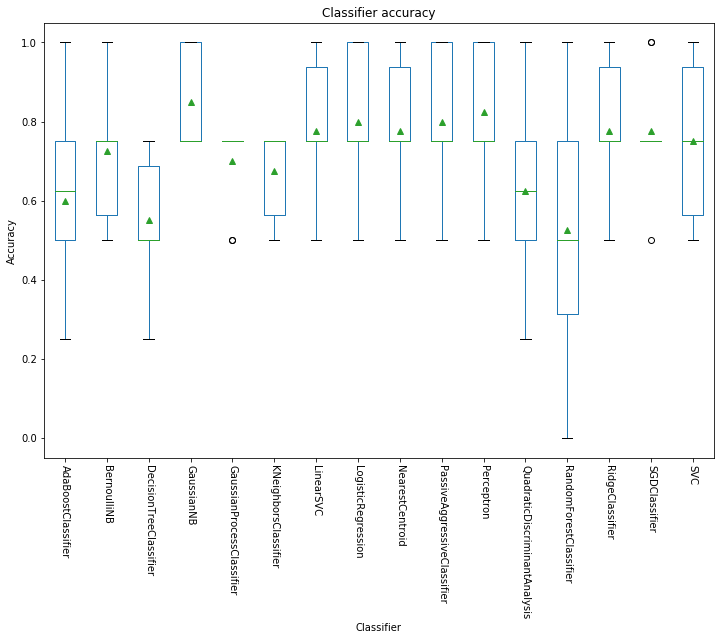

In [31]:
# Plot results
pd.DataFrame(
    df['test_score'].values.tolist(), 
    index=df.index
).T.plot.box(
    figsize=(12,8), 
    rot=-90, 
    sort_columns=True,
    showmeans=True
)
plt.title("Classifier accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Classifier")
plt.show()